# Magnetic field produced by prisms

This code illustrates how to compute the magnetic field components produced by homogeneous rectangular prisms.

### Things we have to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gravmag import rectangular_prism_fields as rpf
from gravmag import plot_functions as plf

### Model

In [2]:
# Create a model formed by prisms
model = np.array([[2000., 3000., -1500., -500., 10., 1010.], 
                  [1600., 2600., -2500., -1500., 10., 1010.], 
                  [-10000., 10000., 1500., 2500., 10., 1010.],
                  [-3000., -2000., -10000., 1500., 10., 1010.]])

# magnetization of each prism
# first, second and third columns contain
# the magnetization intensity (in A/m), inclination 
# and declination (in degrees) of the sources
h = 1
inc = -45
dec = 50
magnetization = np.array([[h, inc, dec],
                          [h, inc, dec],
                          [h, inc, dec],
                          [h, inc, dec]])

### Points were we compute the synthetic data

In [3]:
# number of points along x and y
shape = (100, 100)

# minimum x, maximum x, minimum y and maximum y
area = [-5000, 5000, -4000, 6000]

# coordinates 
xp = np.linspace(area[0], area[1], shape[0])
yp = np.linspace(area[2], area[3], shape[1])
yp, xp = np.meshgrid(yp, xp)
yp = np.ravel(yp)
xp = np.ravel(xp)
zp = np.zeros_like(yp) - 150

coordinates = np.vstack([xp, yp, zp])

### Main field

In [4]:
# reference point
yc, xc = 0, 1000

# polynomial function defining the inclination (degrees)
I0 = 60 - 1e-5*(xp-xc) + 3e-4*(yp-yc) + 1e-8*(xp-xc)*(xp-xc) + 1e-8*(yp-yc)*(yp-yc)

# polynomial function defining the declination (degrees)
D0 = 43 + 6e-5*(xp-xc) + 1e-4*(yp-yc) + 3e-9*(xp-xc)*(xp-xc) + 4e-9*(yp-yc)*(yp-yc)

# polynomial function defining the intensity (nT)
F0 = 23400 + 1e-3*(xp-xc) + 1e-3*(yp-yc) + 0*(xp-xc)*(xp-xc) + 0*(yp-yc)*(yp-yc)

# Cartesian components of the main field
cosI0 = np.cos(np.deg2rad(I0))
sinI0 = np.sin(np.deg2rad(I0))
cosD0 = np.cos(np.deg2rad(D0))
sinD0 = np.sin(np.deg2rad(D0))
Fx = F0*cosI0*cosD0
Fy = F0*cosI0*sinD0
Fz = F0*sinI0

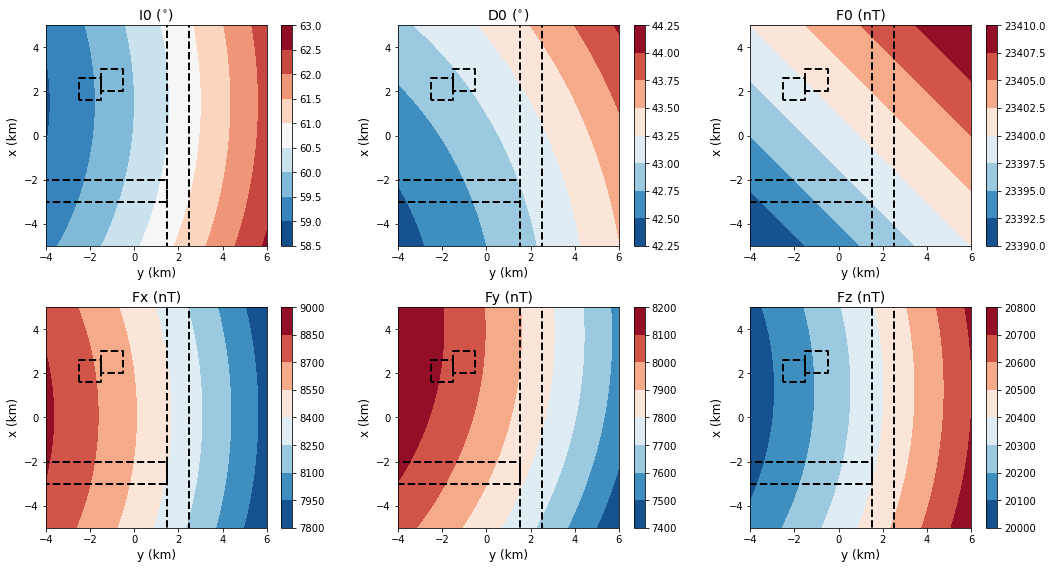

In [5]:
fields = [I0, D0, F0, Fx, Fy, Fz]
windows = [1, 2, 3, 4, 5, 6]
titles = ['I0 ($^{\circ}$)', 'D0 ($^{\circ}$)', 'F0 (nT)',
          'Fx (nT)', 'Fy (nT)', 'Fz (nT)']

plt.figure(figsize=(15,8))

for w, window in enumerate(windows):

    plt.subplot(2,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.ylabel('x (km)', fontsize=12)
    plt.xlabel('y (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Synthetic data

In [6]:
# Compute the scalar magnetic potential
V = rpf.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_potential')

# Compute the magnetic field components
bx = rpf.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_x')
by = rpf.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_y')
bz = rpf.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_z')
b_amp = np.sqrt(bx**2 + by**2 + bz**2)

# Compute the total-field anomaly
tfa = np.sqrt((Fx+bx)**2 + (Fy+by)**2 + (Fz+bz)**2) - F0

# Compute the approximated total-field anomaly by using the
# average main geomagnetic field on the simulated area
mean_I0 = np.mean(I0)
mean_D0 = np.mean(D0)
cos_mean_I0 = np.cos(np.deg2rad(mean_I0))
sin_mean_I0 = np.sin(np.deg2rad(mean_I0))
cos_mean_D0 = np.cos(np.deg2rad(mean_D0))
sin_mean_D0 = np.sin(np.deg2rad(mean_D0))
Fx_hat = cos_mean_I0*cos_mean_D0
Fy_hat = cos_mean_I0*sin_mean_D0
Fz_hat = sin_mean_I0
approx_tfa = Fx_hat*bx + Fy_hat*by + Fz_hat*bz
diff_tfa = approx_tfa - tfa

### Plot the data

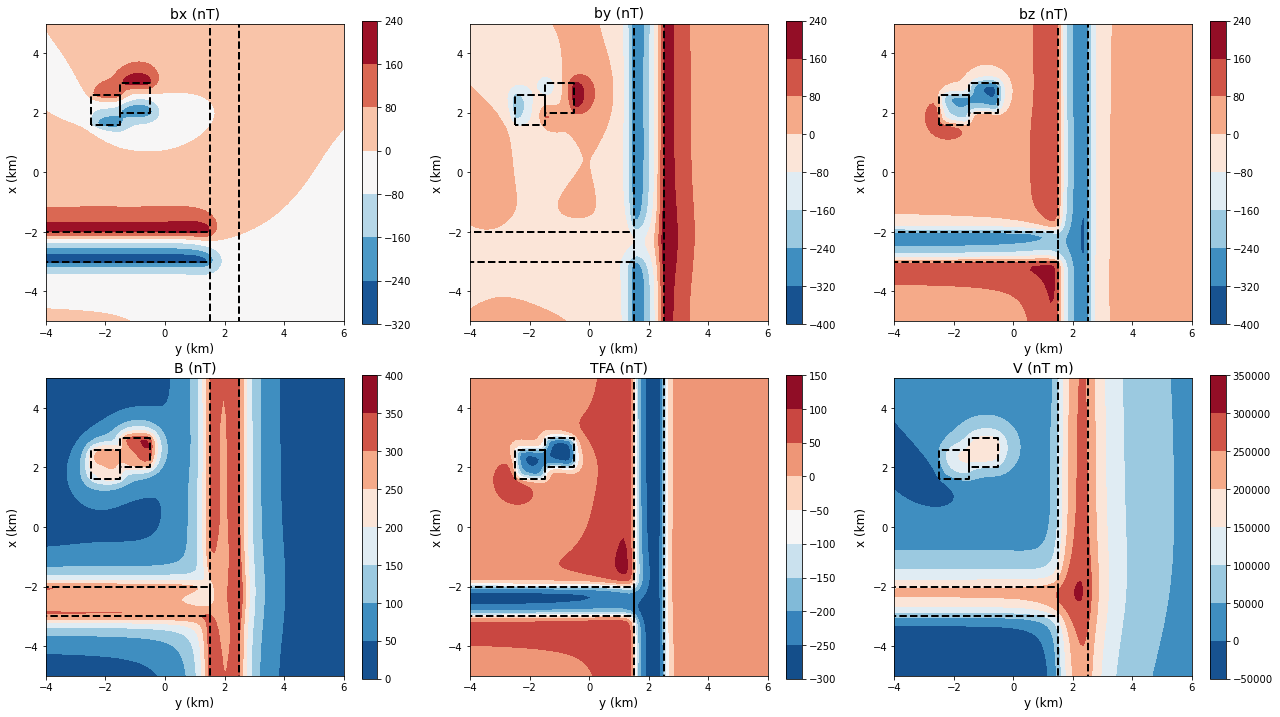

In [7]:
fields = [bx, by, bz, b_amp, tfa, V]
windows = [1, 2, 3, 4, 5, 6]
titles = ['bx (nT)', 'by (nT)', 'bz (nT)', 
          'B (nT)', 'TFA (nT)', 'V (nT m)']

plt.figure(figsize=(18,10))

for w, window in enumerate(windows):

    plt.subplot(2,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.ylabel('x (km)', fontsize=12)
    plt.xlabel('y (km)', fontsize=12)

plt.tight_layout()

plt.show()

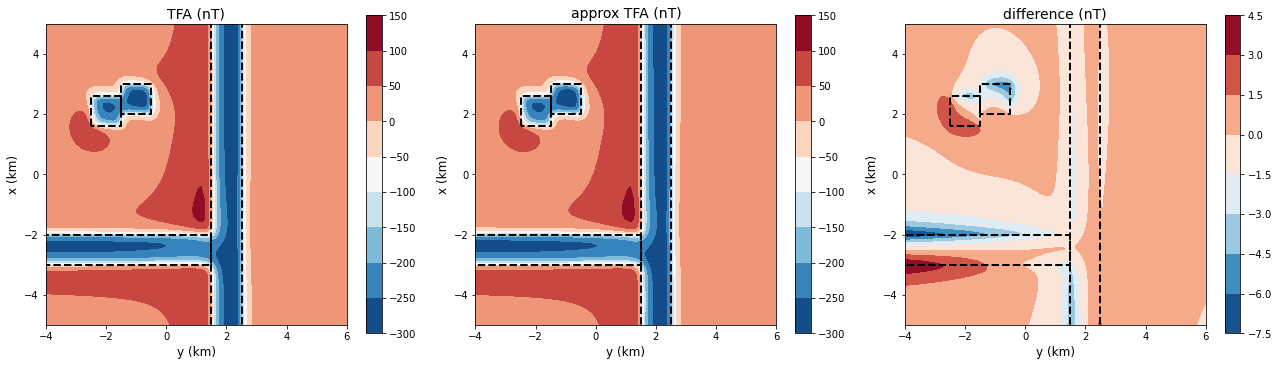

In [8]:
fields = [tfa, approx_tfa, diff_tfa]
windows = [1, 2, 3]
titles = ['TFA (nT)', 'approx TFA (nT)', 'difference (nT)']

plt.figure(figsize=(18,5))

for w, window in enumerate(windows):

    plt.subplot(1,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.ylabel('x (km)', fontsize=12)
    plt.xlabel('y (km)', fontsize=12)

plt.tight_layout()

plt.show()